In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

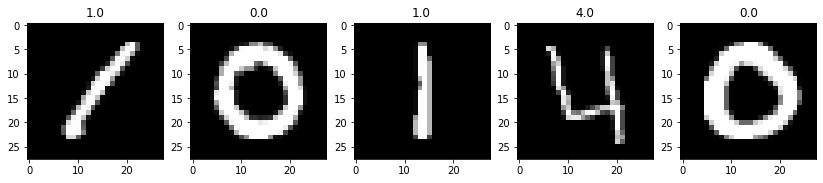

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [8]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [9]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

### Вычисляем угол и длину вектора градиента

In [10]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [11]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

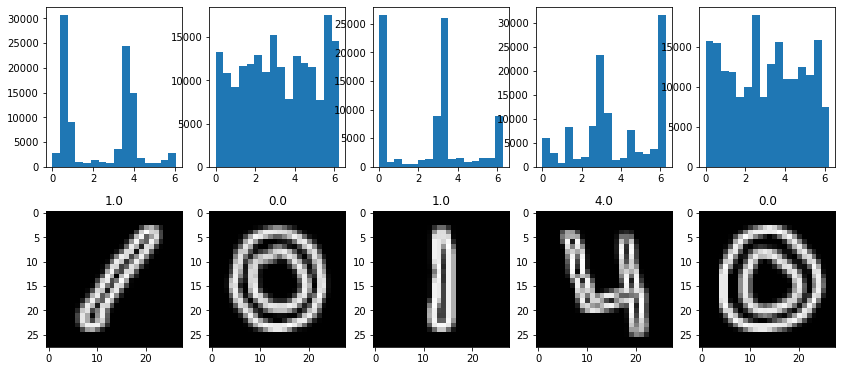

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

### Вычисляем гистограммы градиентов


In [13]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [14]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [15]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [16]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

### HOG DESCRIPTOR

In [26]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [31]:
train_img = np.uint8(train_img)
test_img = np.uint8(test_img)
train_hog = []
for i in range(len(train_img)):
    train_hog.append(hog.compute(train_img[i]))

test_hog = []
for i in range(len(test_img)):
    test_hog.append(hog.compute(test_img[i]))

train_hog = np.array(train_hog)
test_hog = np.array(test_hog)

## Нормируем вектор HOG дескрипторов

train_hog = train_hog / np.linalg.norm(train_hog, axis=1)[:, None]
test_hog = test_hog / np.linalg.norm(test_hog, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [32]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hog, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов


In [33]:
centroids = np.zeros((10, train_hog.shape[1]), dtype=np.float32)

In [34]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [35]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

### Оцениваем качество решение на валидационной выборке

In [36]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.8841666666666667


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       816
         1.0       0.92      0.95      0.93       909
         2.0       0.89      0.89      0.89       846
         3.0       0.89      0.87      0.88       937
         4.0       0.91      0.89      0.90       839
         5.0       0.85      0.84      0.84       702
         6.0       0.94      0.93      0.94       785
         7.0       0.87      0.85      0.86       893
         8.0       0.81      0.84      0.82       835
         9.0       0.87      0.83      0.85       838

    accuracy                           0.88      8400
   macro avg       0.88      0.88      0.88      8400
weighted avg       0.88      0.88      0.88      8400



In [38]:

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[766   9   2   1   2   4  10   2  20   0]
 [  0 861   5   1  28   1   0   7   6   0]
 [ 13   6 754  21   7   7   3   6  28   1]
 [  8   0  18 817   1  40   0   7  38   8]
 [  2  21  18   1 744   1  10   7   5  30]
 [  8   1   4  39   2 587  20   2  39   0]
 [ 14  14   1   0   1  15 732   0   8   0]
 [  2   7  28   8  13   2   0 763   7  63]
 [ 31   7  12  21  13  29   5   6 704   7]
 [ 10  13   2   6   6   2   0  81  19 699]]


## Предсказания на тестовыйх данных


In [40]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hog[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

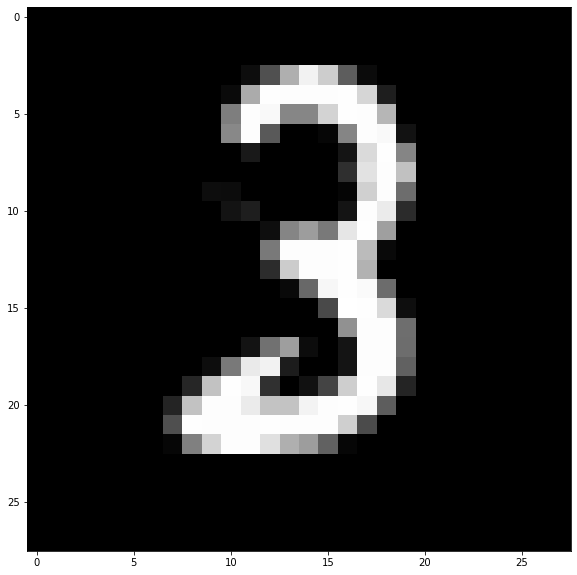

In [41]:
ig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

### Готовим файл для отправки

In [42]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))